In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
% matplotlib inline
#check to see if I can control how big each holdout set is, do with rms error

from sklearn.cross_validation import cross_val_score 
from sklearn.cross_validation import KFold
import sklearn.preprocessing as pp
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Lasso
from sklearn.decomposition import RandomizedPCA
from sklearn.linear_model import Ridge
from sklearn import metrics
from sklearn import cross_validation
from sklearn.datasets import load_digits
from sklearn.learning_curve import learning_curve
import sklearn.decomposition
import sklearn.ensemble as sk
from sklearn import linear_model

import random
import sys
from scipy import stats
from regression_functions import *

#Import Data

In [2]:
pod_number = 'F4'

In [3]:
df_all = pd.io.parsers.read_csv(filepath_or_buffer = 'data/F4_raw_features.csv', parse_dates = [0], index_col = 0)

##Declare whether to process raw or filtered data.

In [4]:
which_data = 0    #1 = filtered, 0 = raw
ref_column, leave_out_pod, pod_ozone = declare_filt_or_raw_dataset(which_data)

####Add a 'day' column to the dataframe, and separate the data into training and holdout.

In [5]:
df_tr, df_hold, days_tr = add_day_sep_tr_and_holdout(df_all, ref_column)

####Call the scaling function and create a dataframe with scaled data.

In [6]:
df_scaled, features = scale_features_and_create_day_column(df_tr, ref_column)

####Create a custom cross-validation function that holds out each day.

In [7]:
lol = create_custom_cv(df_scaled)

#Linear Regression with Base Features

In [8]:
base_features = [pod_ozone,'Temp','Rh']

In [9]:
#Define the model.
lin_regr = linear_model.LinearRegression()
#find the MSE
MSE_CV, MSE_T = cross_validation_by_day(lin_regr, base_features, df_scaled, days_tr, ref_column)

Cross-Validation MSE:  48  Training MSE:  34


####Plot the learning curve for a linear regression with the base features.

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

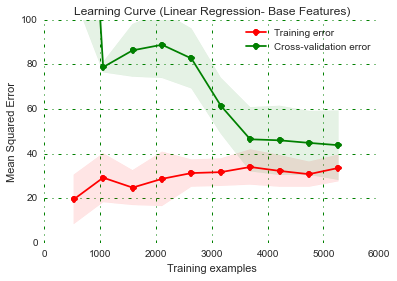

In [10]:
plot_learning_curve(lin_regr, "Learning Curve (Linear Regression- Base Features)", df_tr[base_features].values, df_tr[ref_column].values, (0,100), lol, np.array([ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]), 'mean_squared_error')

The MSE is high for the cross-validation set in this plot, and the training and cross-validation scores come together in this plot tells us that we have resonably high bias. Create more features and add polynomial effects to reduce bias. 

###Plot the residuals and comparison curves.

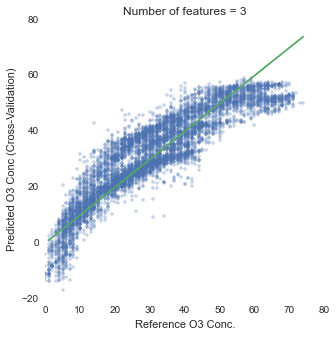

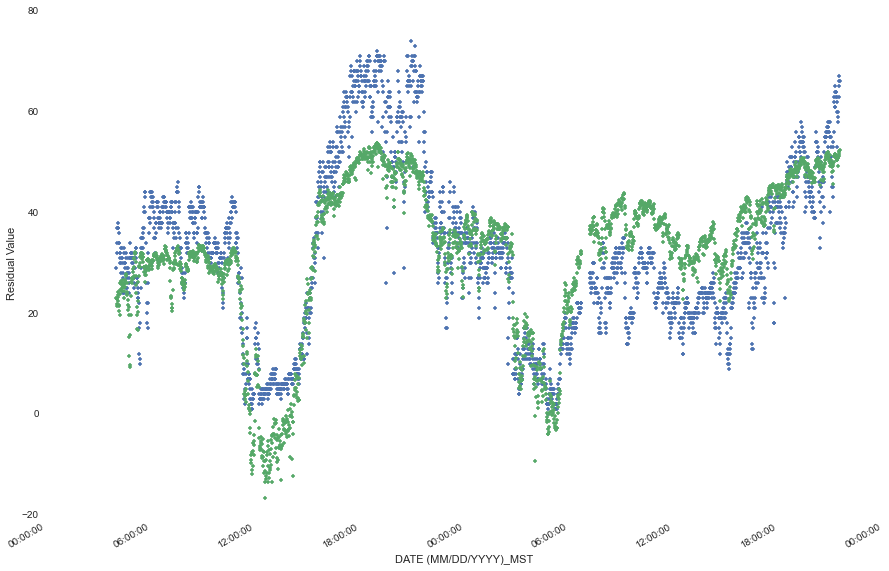

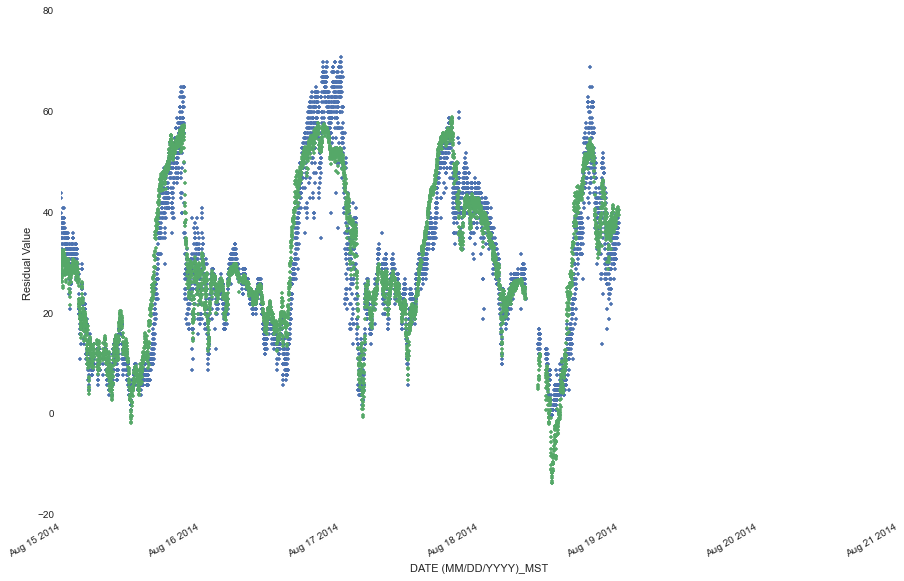

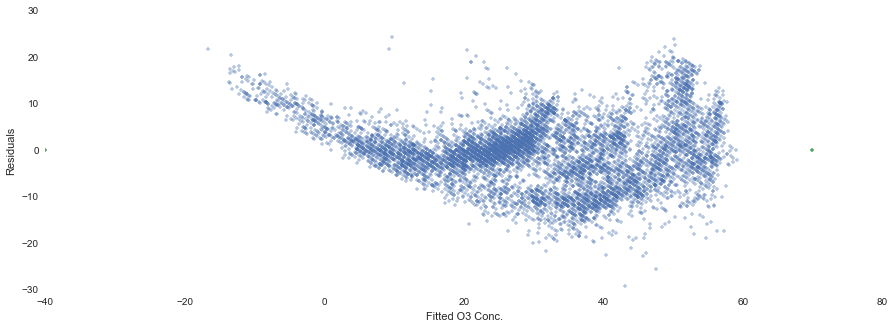

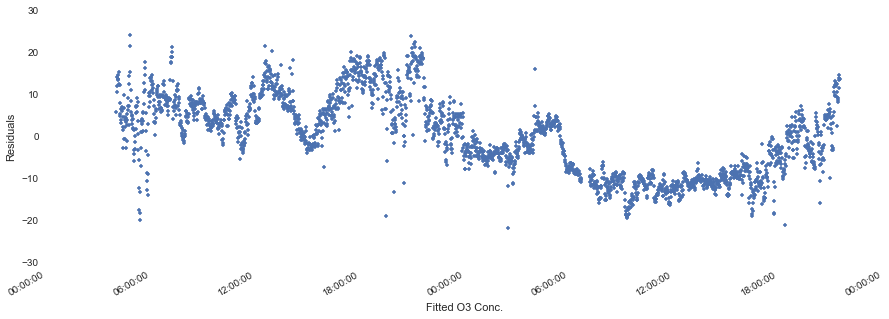

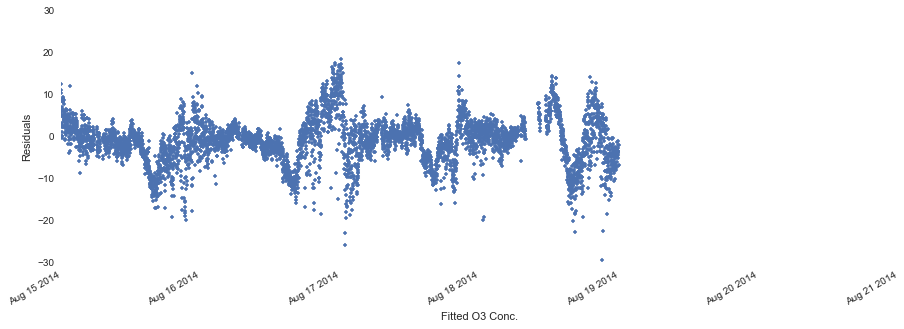

In [10]:
num_good_feat = len(base_features)
df_lin_regr_best_feat = find_fitted_cv_values_for_best_features(df_tr, base_features, num_good_feat, linear_model.LinearRegression(), days_tr, ref_column)
fitted_vs_ref_plot(df_lin_regr_best_feat, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat, pod_number, 2, ref_column)
resid = plot_resid_vs_conc(df_lin_regr_best_feat, ref_column)
plot_resid_vs_time(resid, pod_number, 1)
plot_resid_vs_time(resid, pod_number, 2)

###Linear Regression with All Features.

In [12]:
all_features = list(df_tr.ix[:,1:len(df_all.columns)-1])
#find the MSE
MSE_CV, MSE_T = cross_validation_by_day(lin_regr, all_features, df_scaled, days_tr, ref_column)

Cross-Validation MSE:  76  Training MSE:  6


####Plot a learning curve with all features.

In [17]:
plot_learning_curve(lin_regr, "Learning Curve (Linear Regression- All Features)", df_tr[all_features].values, df_tr[ref_column].values, (0,100), lol, np.array([ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]), 'mean_squared_error')

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

OverflowError: Allocated too many blocks

The uncertainty in the cross-validation score is enormous, and it's very far away, from the training score, which indicates that we now have high variance, and need to reduce the number of features.

###Plot the residuals and comparison curves.

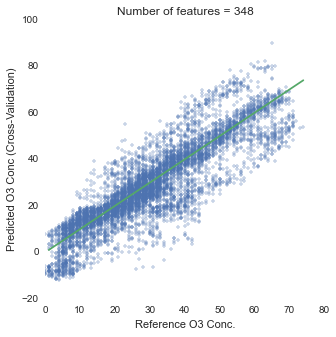

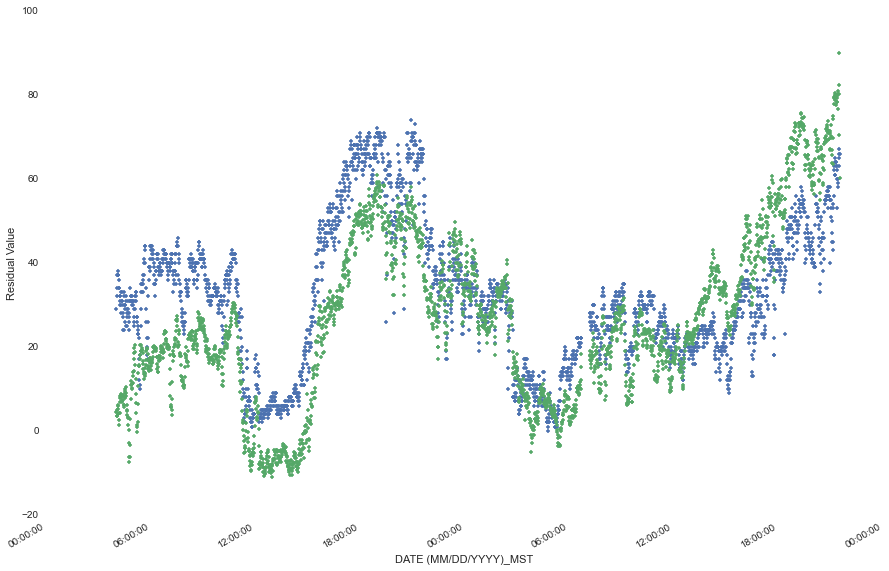

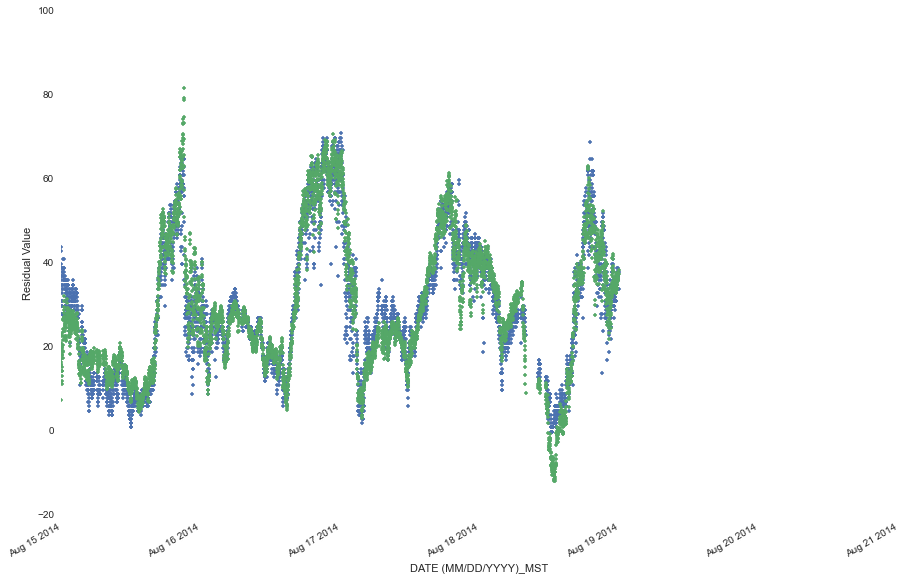

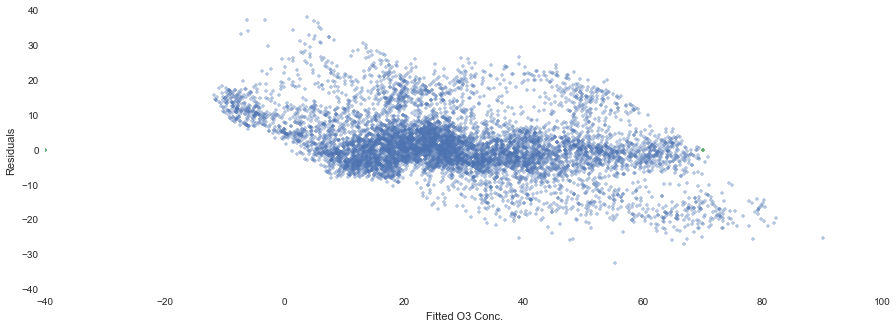

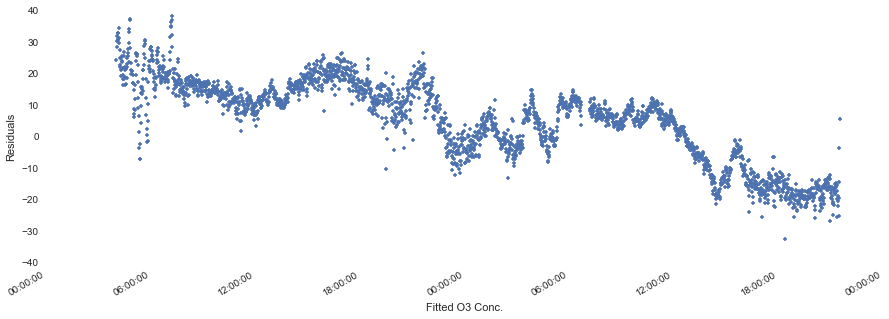

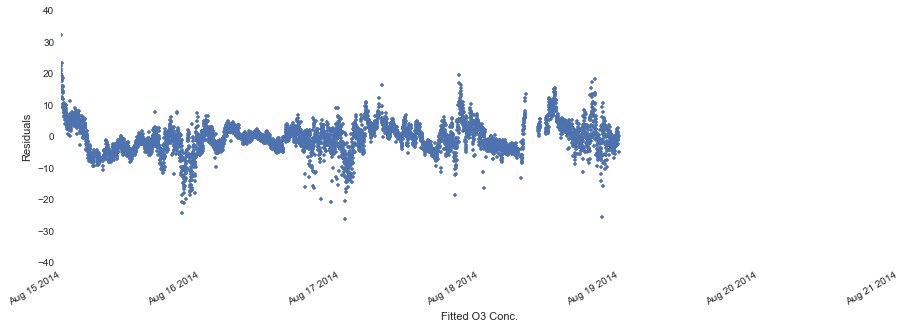

In [13]:
num_good_feat = len(all_features)
df_lin_regr_best_feat = find_fitted_cv_values_for_best_features(df_tr, all_features, num_good_feat, linear_model.LinearRegression(),days_tr, ref_column)
fitted_vs_ref_plot(df_lin_regr_best_feat, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat, pod_number, 2, ref_column)
resid = plot_resid_vs_conc(df_lin_regr_best_feat, ref_column)
plot_resid_vs_time(resid, pod_number, 1)
plot_resid_vs_time(resid, pod_number, 2)

#Forward Selection

####Declare rather you want to use MSE or a custom error function:

In [10]:
error_func = 'custom_mse' #'custom_mse', 'custom_mae' or 'mean_squared_error'

In [11]:
#make a list of features from the column titles in the dataframe
features = list(df_all.columns)
leave_out = ['Zenith Angle [degrees]','UnixTime',leave_out_pod, ref_column,'days from start', 'day']
features = [f for f in features if f not in leave_out]
fs_features, score, MSE = forward_selection_lodo(lin_regr, features, df_tr[[ref_column] + features + ['days from start']].dropna(), error_func, ref_column, lol)

Next best Feature:  ln_O3_int_lead_35 , Score:  350.0 ,
Next best Feature:  temp_cu , Score:  88.7 ,
Next best Feature:  ln_O3_slope_lead_95 , Score:  47.7 ,
Next best Feature:  Temp_slope_lag_110 , Score:  37.3 ,
Next best Feature:  ln_O3_slope_lead_50 , Score:  33.0 ,
Next best Feature:  ln_rh_slope_lead_80 , Score:  30.0 ,
Next best Feature:  temp_rh_slope_lead_110 , Score:  26.3 ,
Next best Feature:  Temp_slope_lead_50 , Score:  25.0 ,
Next best Feature:  e2v03_slope_lead_95 , Score:  23.7 ,
Next best Feature:  o3_temp_int_lag_35 , Score:  22.7 ,
Next best Feature:  e2v03_slope_lag_5 , Score:  22.0 ,
Next best Feature:  ln_temp_slope_lag_80 , Score:  21.7 ,
Next best Feature:  ln_o3_temp_int_lead_95 , Score:  21.3 ,
Next best Feature:  ln_O3_int_lead_20 , Score:  21.0 ,
Next best Feature:  ln_03_mult_ln_temp , Score:  20.3 ,
Next best Feature:  Rh_slope_lead_80 , Score:  18.7 ,
Next best Feature:  e2v03_slope_lead_110 , Score:  18.3 ,
Next best Feature:  e2v03_int_slide_2_to_12_lea

In [12]:
def plot_error_vs_features(score, MSE):
    x = range(0, len(score))
    plt.plot(x, score, 'bo-')
    plt.plot(x, MSE, 'ro-')
    plt.ylim((0,100))
    plt.xlabel('Number of Features')
    plt.ylabel('Error')
    plt.grid(b=True, which='major', color='g', linestyle='-.')
    print 'Custom Score: ', score
    print 'MSE: ', MSE

Custom Score:  ['350.0', '88.7', '47.7', '37.3', '33.0', '30.0', '26.3', '25.0', '23.7', '22.7', '22.0', '21.7', '21.3', '21.0', '20.3', '18.7', '18.3', '18.3', '18.3', '18.3', '18.3', '18.3', '18.3', '18.3', '18.3', '18.0', '18.0', '18.0', '17.7', '16.3', '15.7', '15.7', '15.7', '15.7']
MSE:  ['537.1', '132.1', '91.1', '64.2', '76.2', '69.8', '70.2', '63.3', '68.2', '66.5', '62.4', '62.6', '63.6', '65.0', '57.1', '54.9', '55.9', '55.9', '55.9', '55.9', '55.9', '55.9', '55.9', '55.9', '54.6', '57.8', '58.5', '58.2', '67.2', '63.3', '57.6', '57.8', '58.3', '56.8']


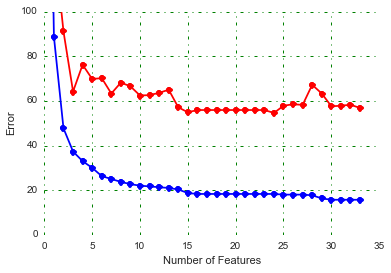

In [13]:
plot_error_vs_features(score, MSE)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


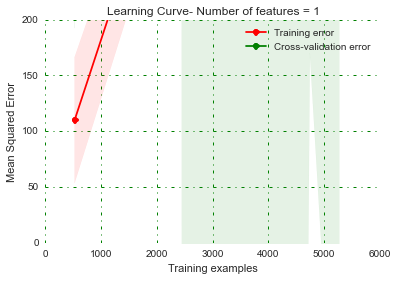

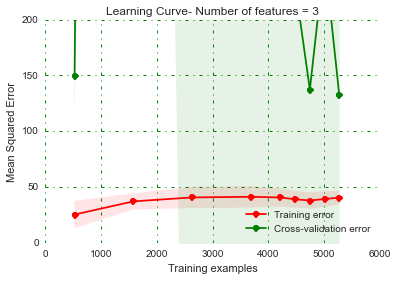

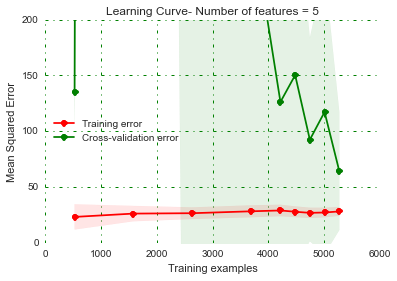

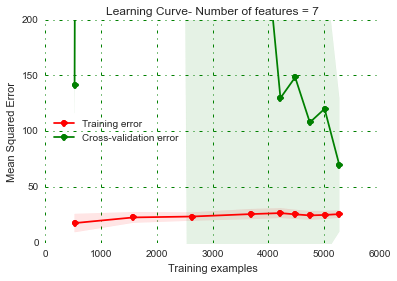

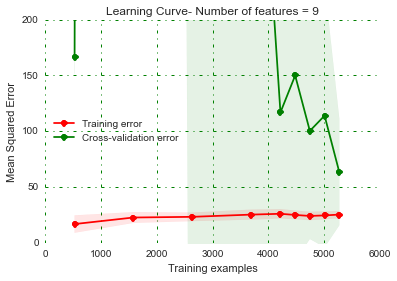

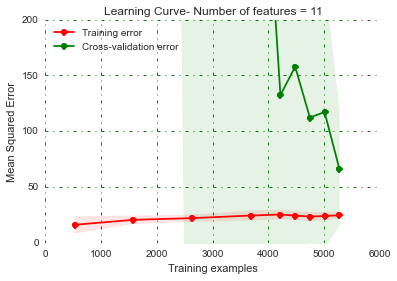

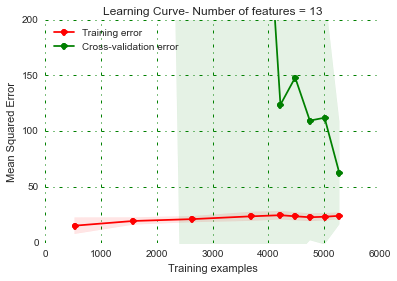

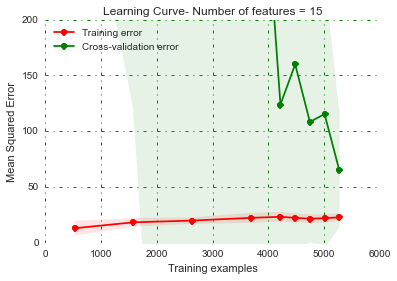

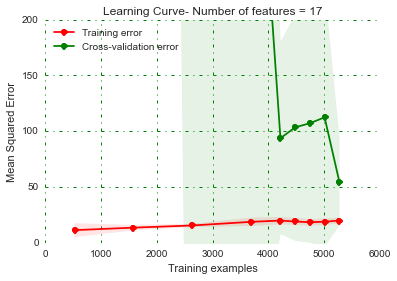

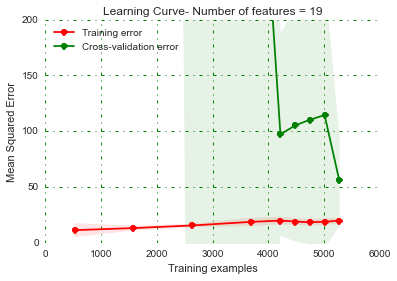

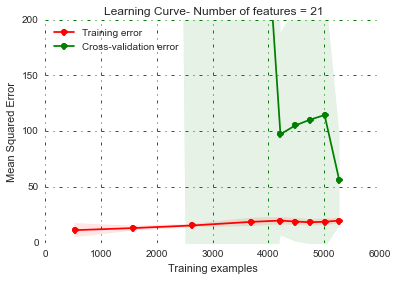

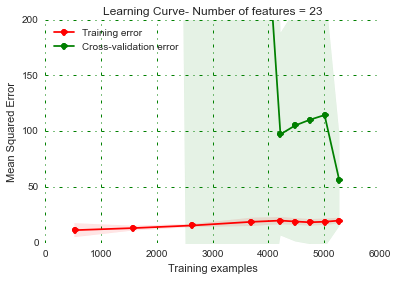

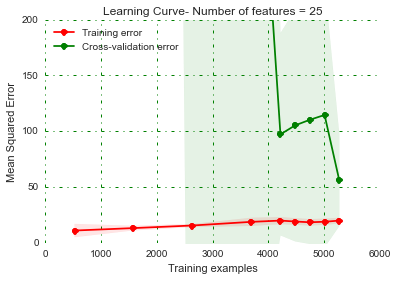

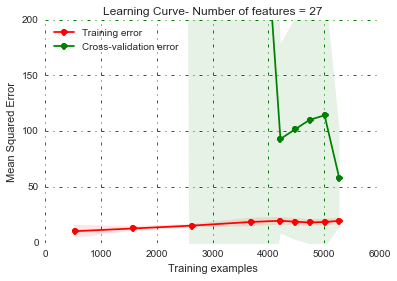

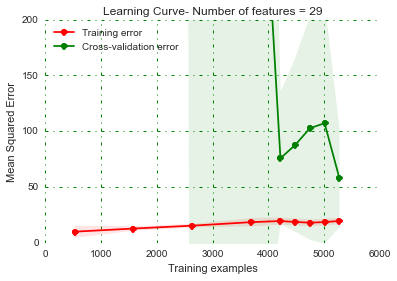

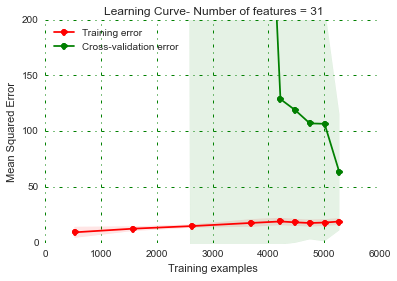

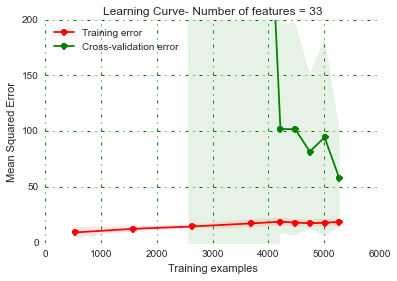

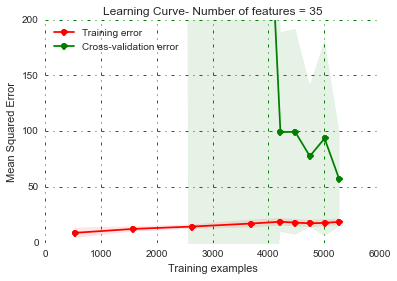

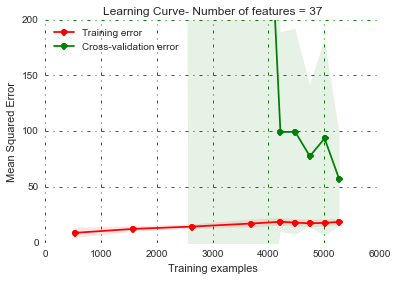

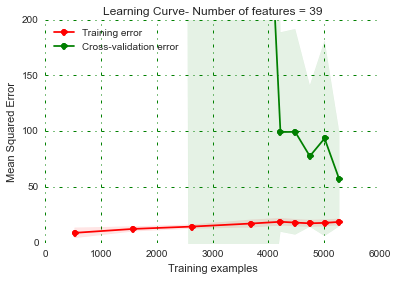

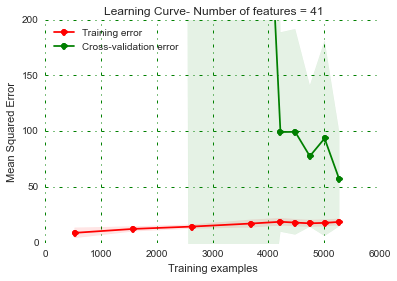

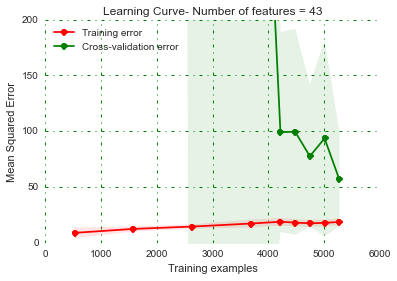

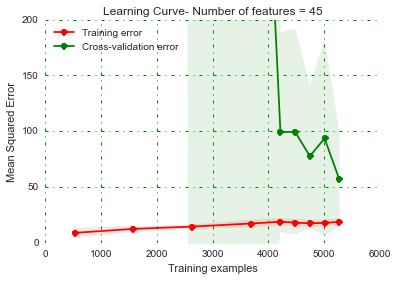

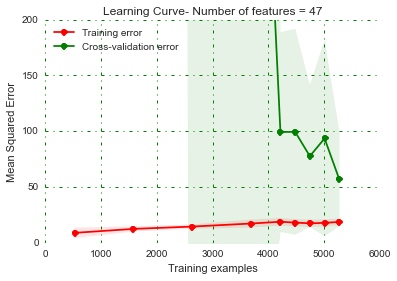

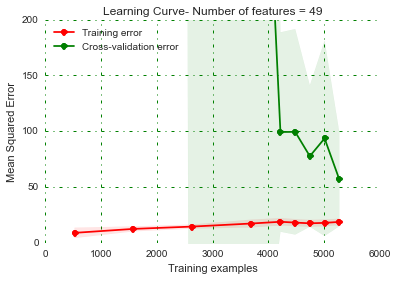

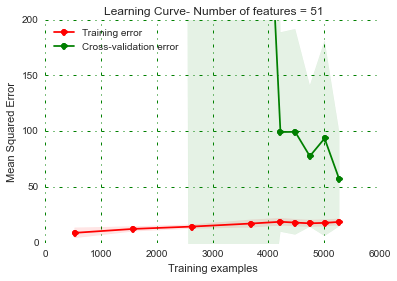

In [22]:
i = 1
while i <= 51:
    #title = "Learning Curve- Number of features = " + str(i)
    plot_learning_curve(lin_regr, "Learning Curve- Number of features = " + str(i), df_tr[fs_features[:i]].values, df_tr[ref_column].values, (0,200), lol, np.array([0.1, 0.3, 0.5, 0.7, 0.8, 0.85, 0.9, 0.95, 1.0]), 'mean_squared_error')
    i += 2

#Check Residuals

###Find predicted ozone values for the holdout data. Enter the number of good features to use for regressions.

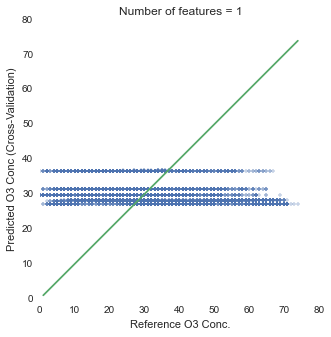

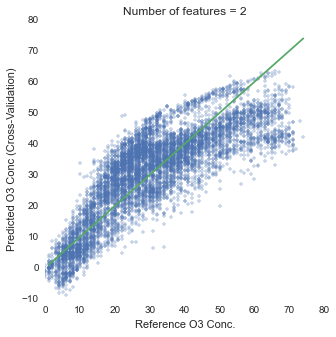

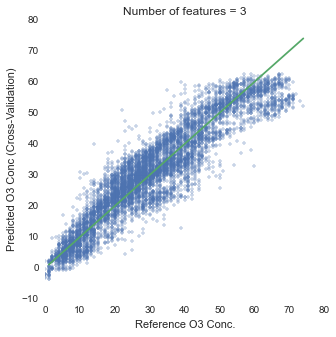

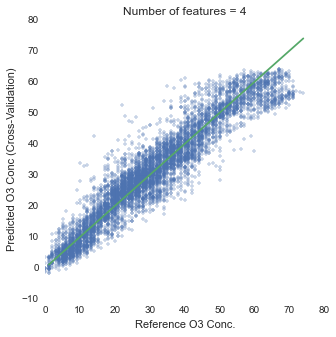

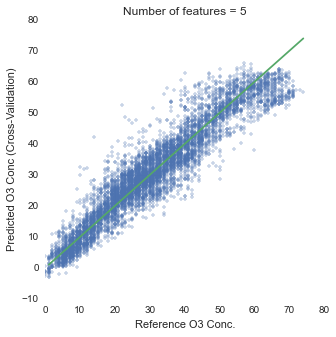

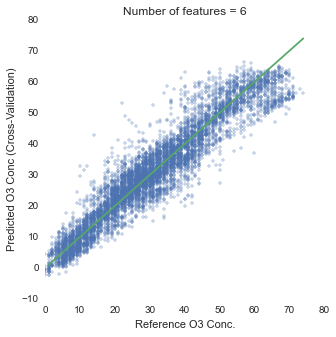

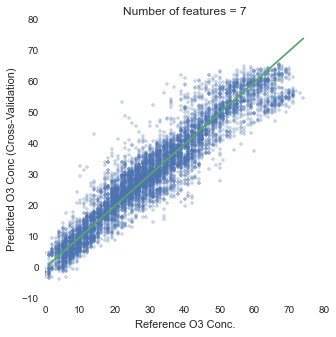

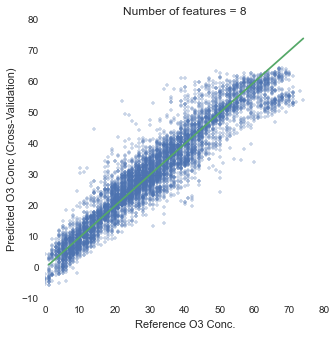

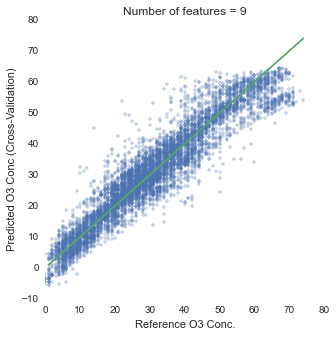

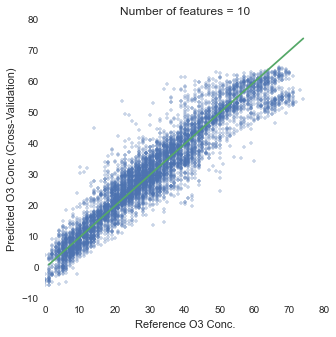

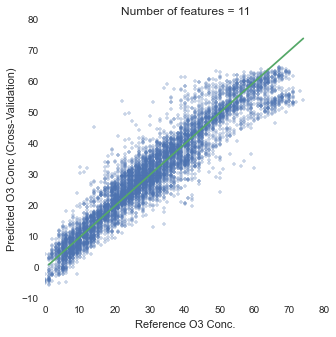

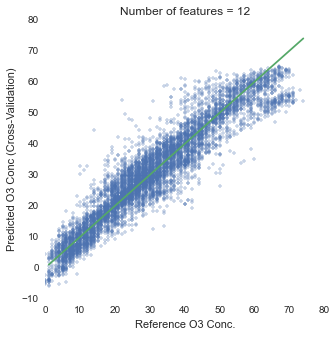

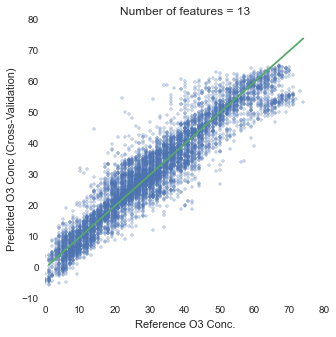

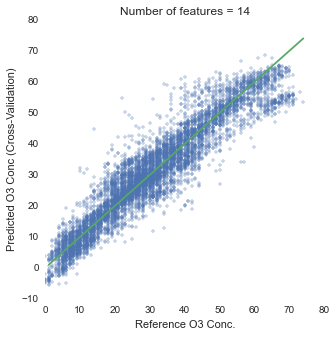

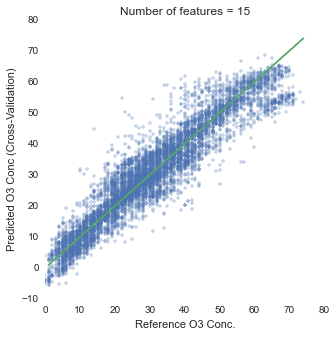

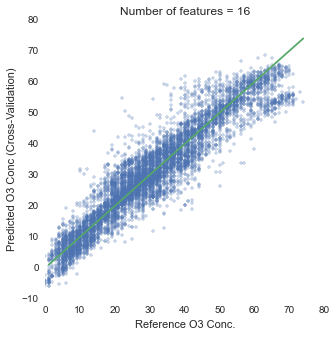

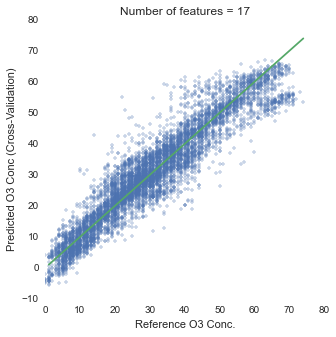

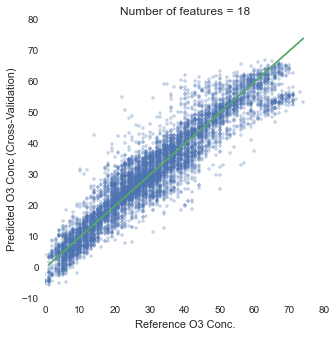

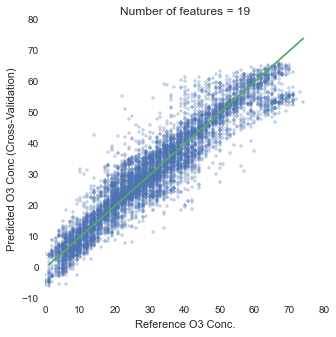

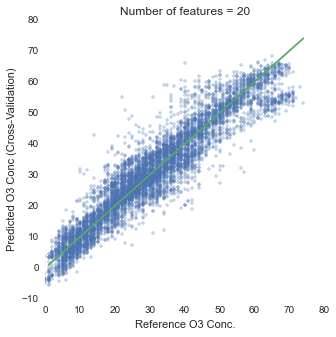

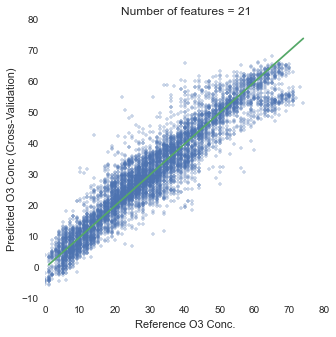

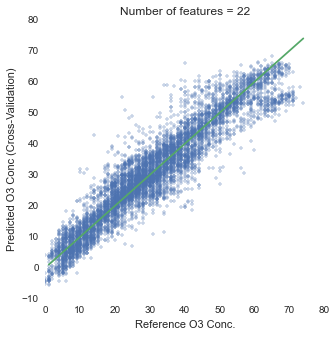

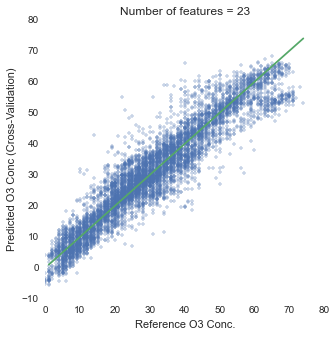

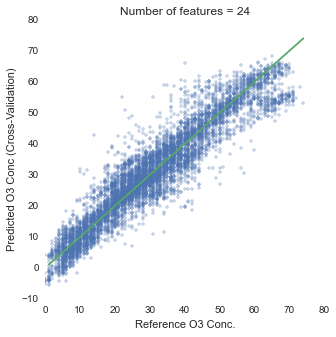

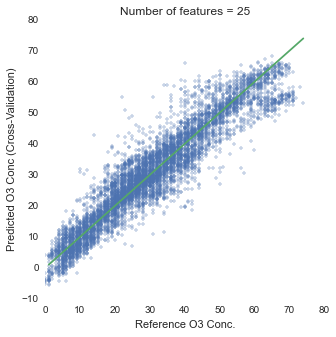

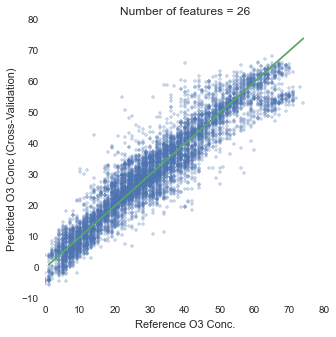

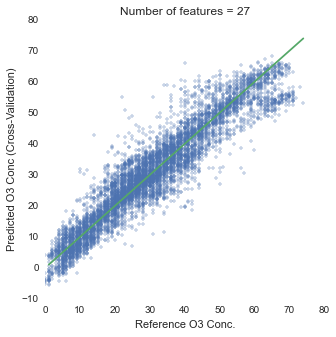

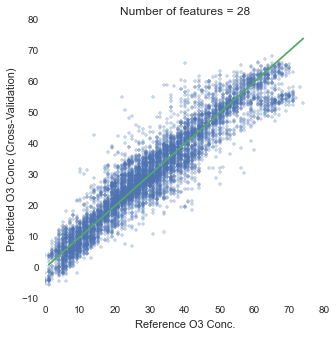

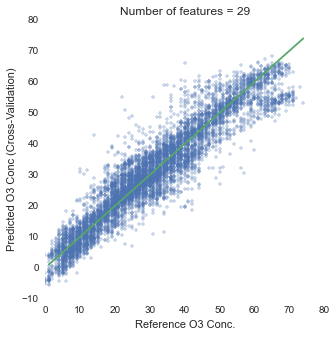

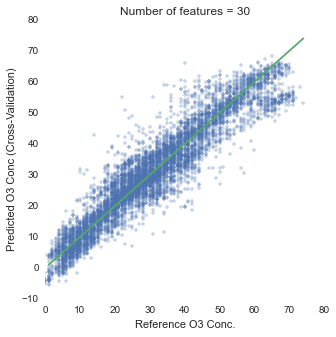

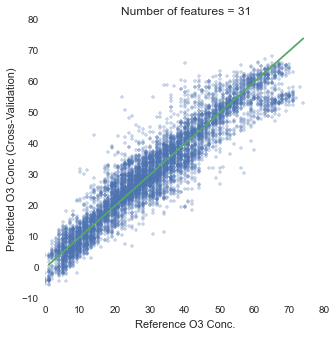

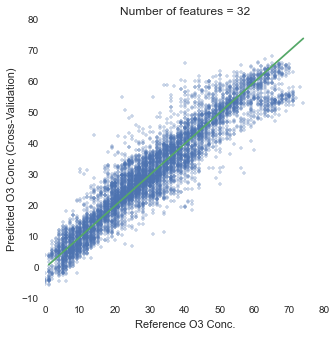

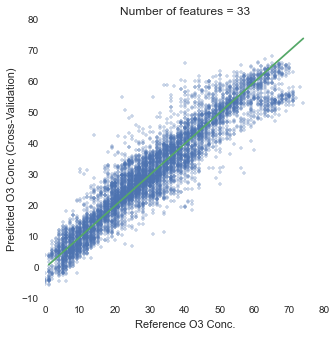

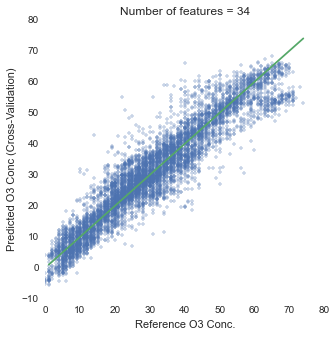

In [21]:
for i in range(1,len(fs_features)):
    num_good_feat = i
    df = find_fitted_cv_values_for_best_features(df_tr, fs_features, num_good_feat, linear_model.LinearRegression(), days_tr, ref_column)
    fitted_vs_ref_plot(df, i, ref_column) 

###Enter the chosen number of features, and plot the cv data and residuals below.

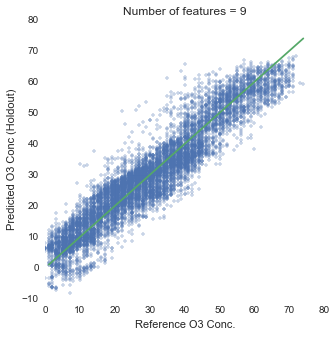

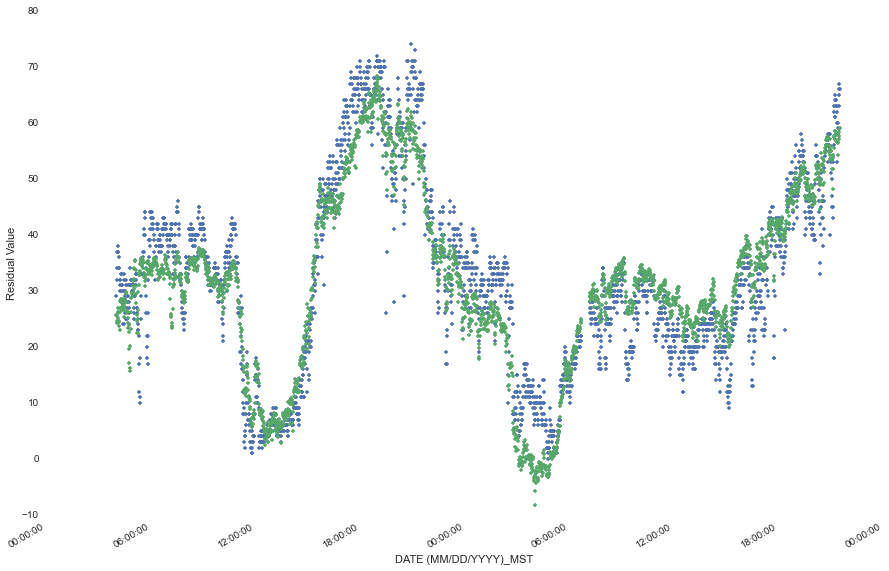

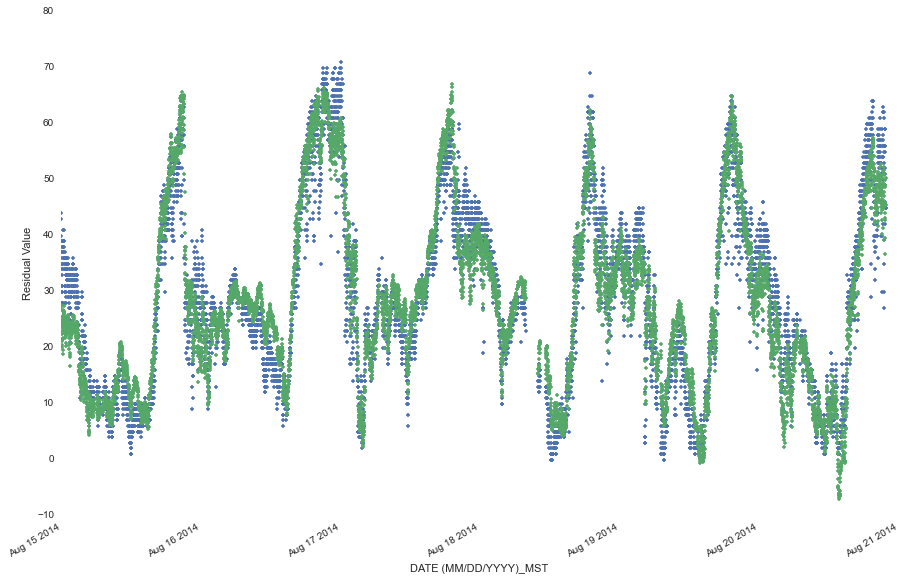

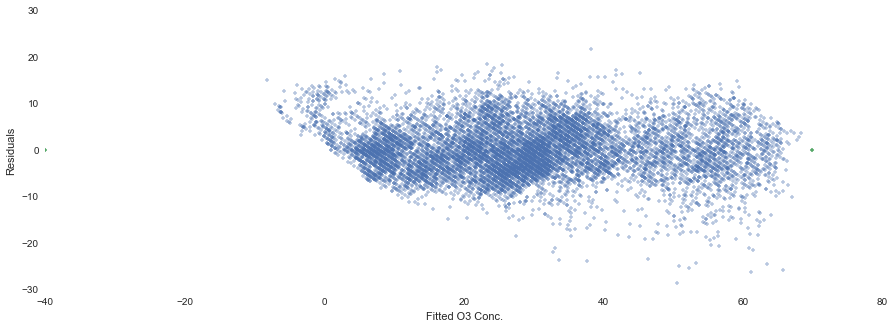

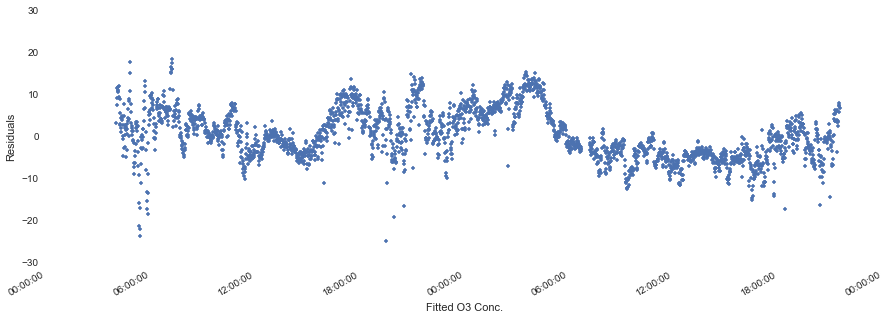

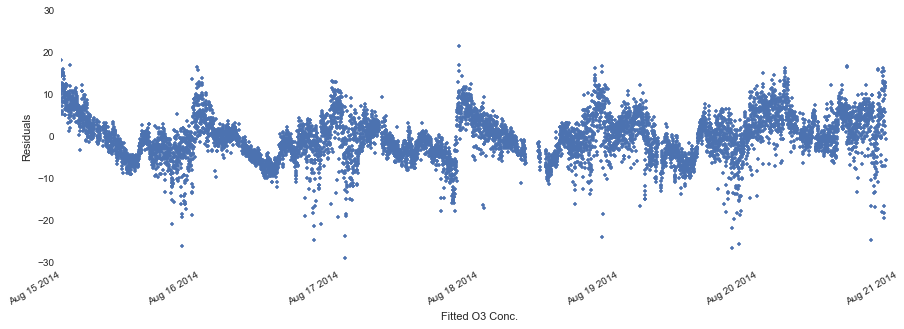

In [82]:
num_good_feat = 9
df_lin_regr_best_feat = find_fitted_cv_values_for_best_features(df_tr, fs_features, num_good_feat, linear_model.LinearRegression())

fitted_vs_ref_plot(df_lin_regr_best_feat, num_good_feat)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat, pod_number, 2, ref_column)
resid = plot_resid_vs_conc(df_lin_regr_best_feat, ref_column)
plot_resid_vs_time(resid, pod_number, 1)
plot_resid_vs_time(resid, pod_number, 2)

#Ridge Regression

In [132]:
#fs_features = ['e2v03','Temp','Rh']
fs_features = features
num_good_feat = len(fs_features)

In [133]:
#define the training data
df_ridge = df_scaled[fs_features[:num_good_feat] + [ref_column] + ['day']].dropna()
X = df_scaled[fs_features[:num_good_feat]].values
y = df_scaled[ref_column].values
#print df_fit[:5]

###Find the best lambda value using cross-validation

In [174]:
def find_best_lambda(Model, features, df, ref_column, scoring_metric):
    lambda_ridge = []
    mean_score_lambda = []
    i = 0.0000000001
    n = 1
    coefs = []

    while i < 1000000:
        #define the model
        model = Model(alpha=i)    
        #fit the ridge regression for the lambda
        model.fit(X, y)
        #record the custom score for this lambda value
        mean_score_lambda.append(avg_cv_score_for_all_days(df, features, ref_column, model, scoring_metric))  
        #record the lambda value for this run
        lambda_ridge.append(i)
        #record the coefficients for this lambda value
        coefs.append(model.coef_)
        
        i = i*1.25
        n += 1  

    #find the lambda value (that produces the lowest cross-validation MSE)  
    best_lambda = lambda_ridge[mean_score_lambda.index(min(mean_score_lambda))]
    
    #record the MSE for this lambda value
    MSE = avg_cv_score_for_all_days(df, features, ref_column, Model(alpha=best_lambda), 'mean_squared_error')
                                
    #plot the coefficients     
    ax = plt.gca()
    ax.set_color_cycle(['b', 'r', 'g', 'c', 'k', 'y', 'm'])

    ax.plot(lambda_ridge, coefs)
    ax.set_xscale('log')
    plt.xlabel('lambda')
    plt.ylabel('weights')
    plt.title(str(Model) + 'coefficients as a function of the regularization')
    plt.show()  
   
    #plot the results
    plt.plot(lambda_ridge, mean_score_lambda)
    ax = plt.gca()
    ax.set_xscale('log')
    plt.xlabel('lambda')
    plt.ylabel('Custom Score')
    
    print 'Best Lambda: ', best_lambda
    print 'Custom Error: ', int(min(mean_score_lambda))
    print 'CV Mean Squared Error: ', int(MSE)
    
    return best_lambda, min(mean_score_lambda), MSE 

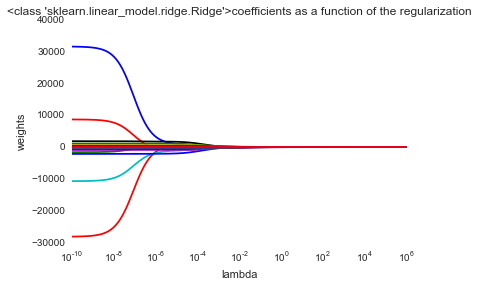

Best Lambda:  2.64697796017e-08
Custom Error:  68
CV Mean Squared Error:  46


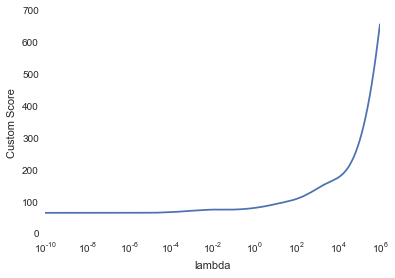

In [175]:
best_lambda, custom_sc, MSE = find_best_lambda(Ridge, fs_features[:num_good_feat], df_ridge, ref_column, 'custom_mse')

####Use the best lambda value found above to find holdout values.

In [156]:
def find_residuals_and_fitted_cv_values(Model, df_scaled, features, df_all):
    model = Model(alpha = best_lambda)

    for d in days:               
        #call the function that defines the training and holdout data
        X_T, y_T, X_H, y_H = make_numpy_arrays_for_tr_and_holdout(features, df_scaled[df_scaled.day != d], df_scaled[df_scaled.day == d], ref_column)  
        #fit the ridge regression for the lambda
        model.fit(X_T, y_T)
        if d == days[0]:
            fitted_holdout_o3 = model.predict(X_H)
        else:
            fitted_holdout_o3 = np.concatenate((fitted_holdout_o3, model.predict(X_H)))
                
    df_ridge_fit = df_all.copy()
    df_ridge_fit['O3_fit'] = fitted_holdout_o3
    return df_ridge_fit

In [165]:
df_ridge_fit = find_residuals_and_fitted_cv_values(Ridge, df_scaled, fs_features[:num_good_feat], df_all)

TypeError: 'RidgeCV' object is not callable

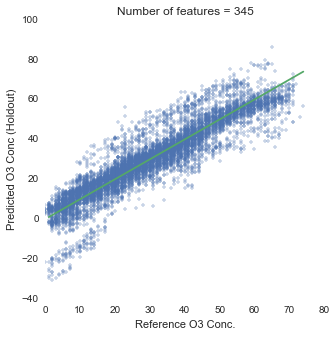

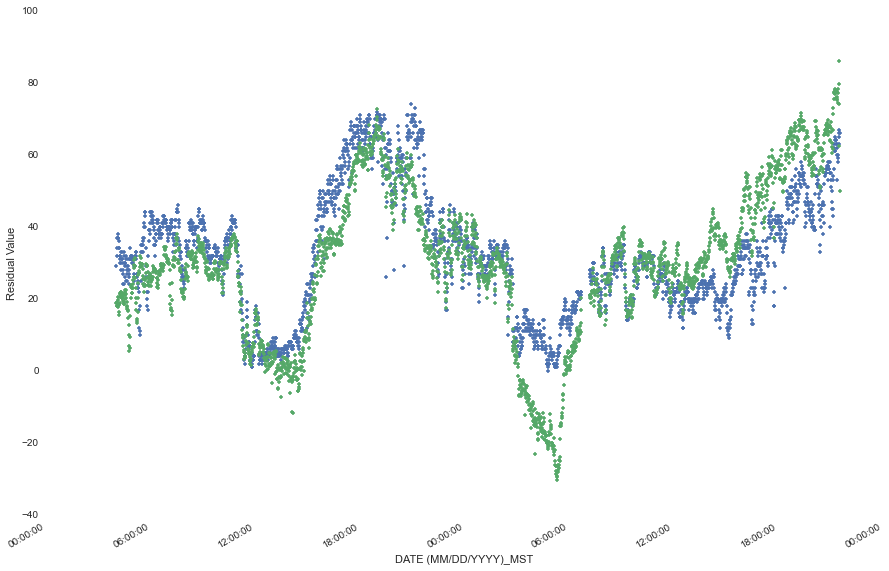

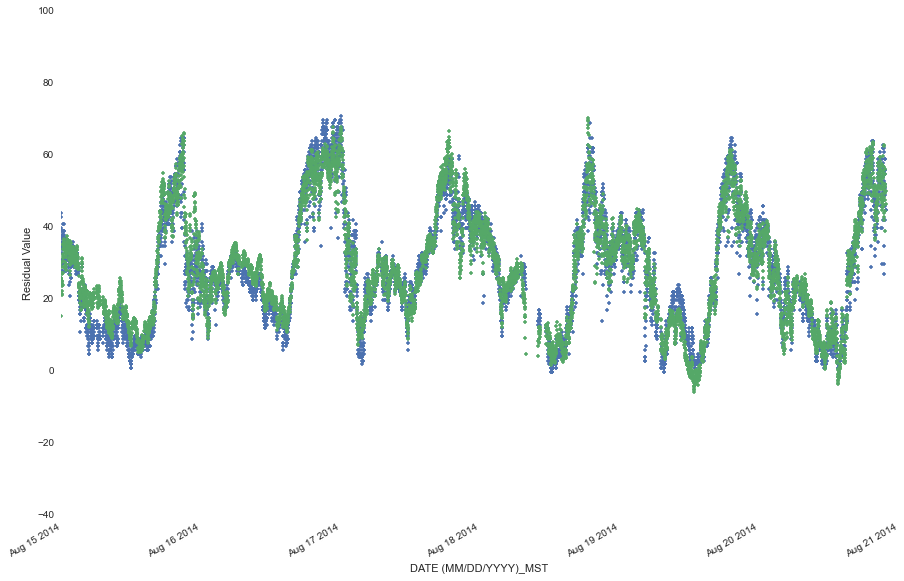

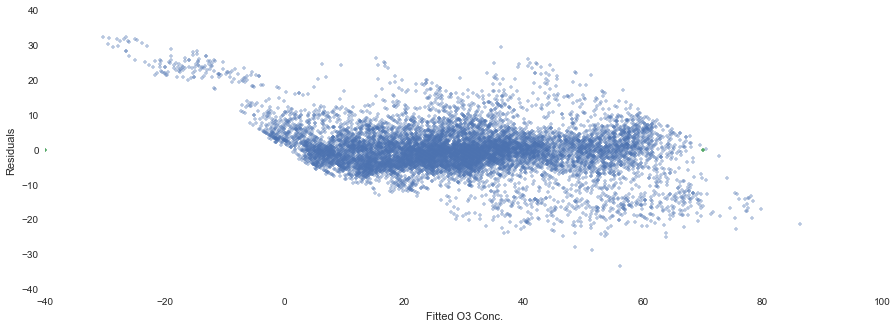

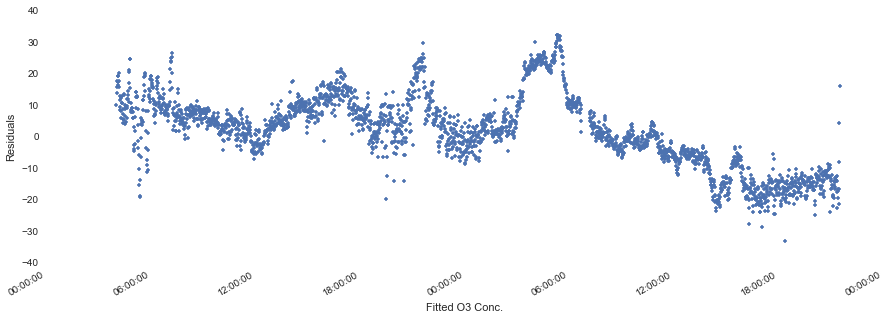

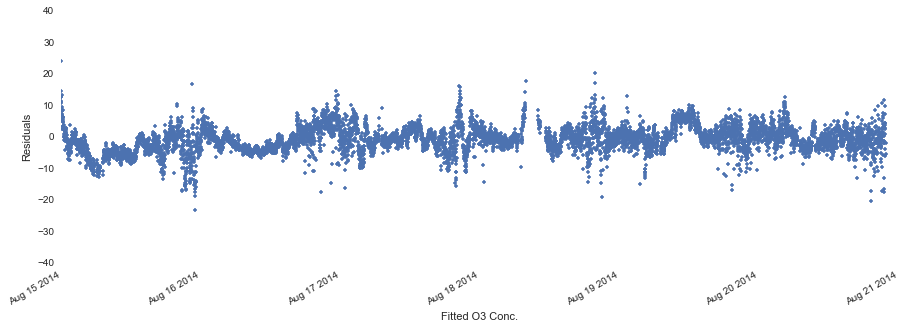

In [158]:
fitted_vs_ref_plot(df_ridge_fit, num_good_feat)
plot_fitted_and_ref_vs_time(df_ridge_fit, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_ridge_fit, pod_number, 2, ref_column)
resid = plot_resid_vs_conc(df_ridge_fit, ref_column)
plot_resid_vs_time(resid, pod_number, 1)
plot_resid_vs_time(resid, pod_number, 2)

In [159]:
ridge.coef_

NameError: name 'ridge' is not defined

#Lasso

In [160]:
#num_good_feat = 34
#define the training data
df_lasso = df_scaled[fs_features[:num_good_feat] + [ref_column]+ ['day']].dropna()
X = df_scaled[fs_features[:num_good_feat]].values
y = df_scaled[ref_column].values
#print df_fit[:5]

/Applications/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:490: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


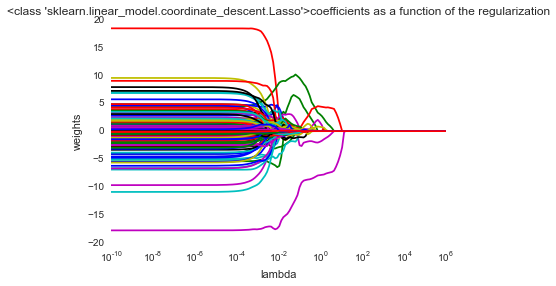

Best Lambda:  3.58732406867e-06
Custom Error:  84
CV Mean Squared Error:  41


ValueError: too many values to unpack

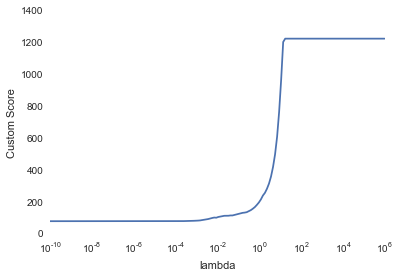

In [163]:
best_lambda, custom_sc, MSE = find_best_lambda(Lasso, fs_features[:num_good_feat], df_scaled, ref_column, 'custom_mse')

####Use the best lambda value found above to find holdout values.

In [162]:
df_fit_lasso = find_residuals_and_fitted_cv_values(Lasso, df_scaled, fs_features[:num_good_feat], df_all)

TypeError: find_residuals_and_fitted_cv_values() takes exactly 4 arguments (6 given)

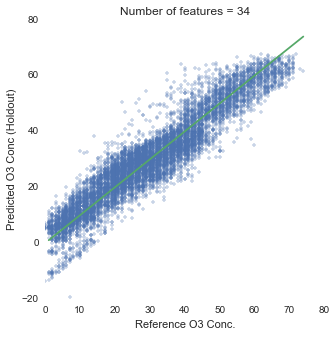

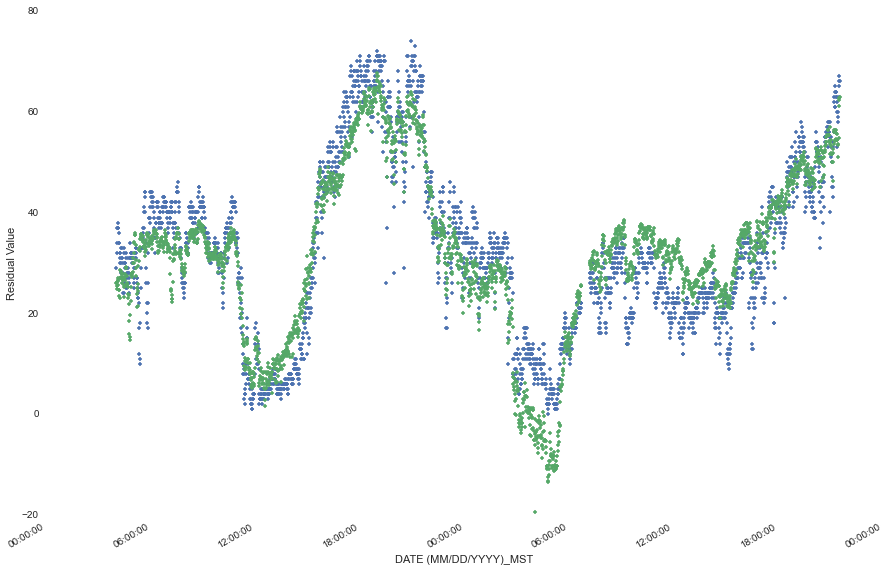

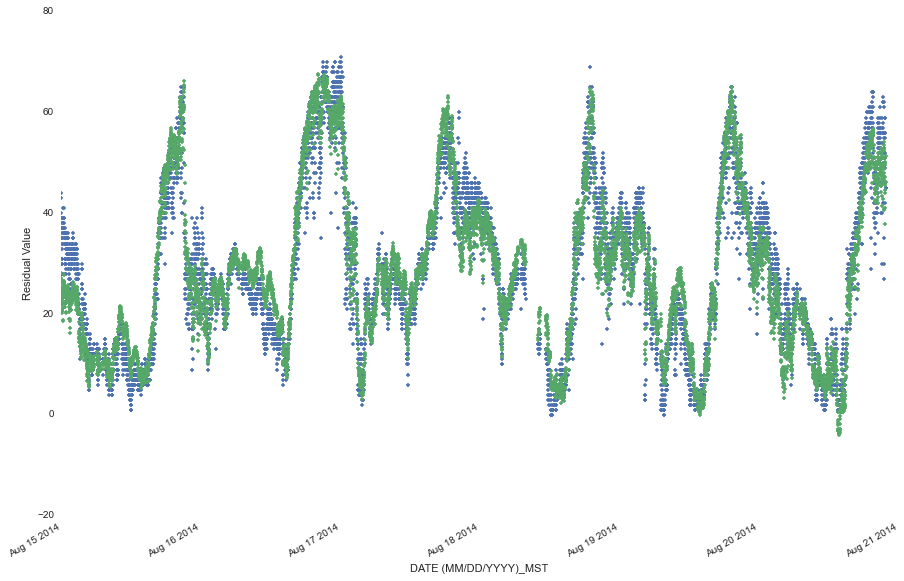

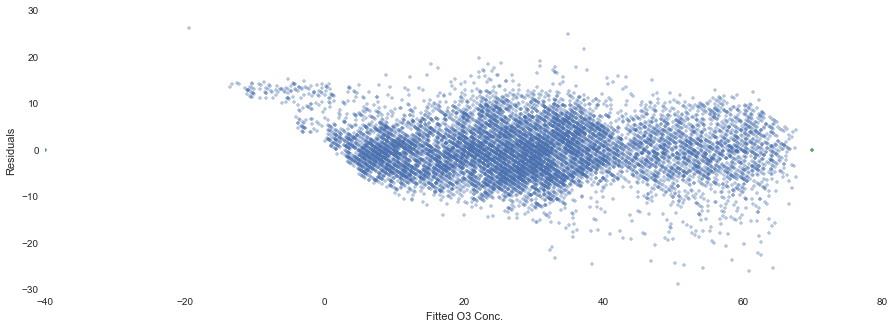

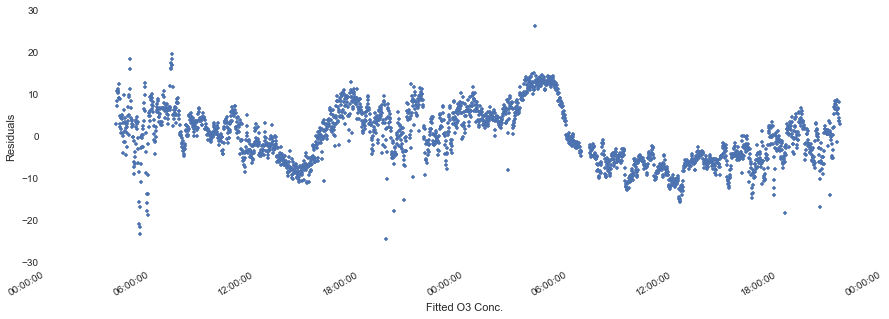

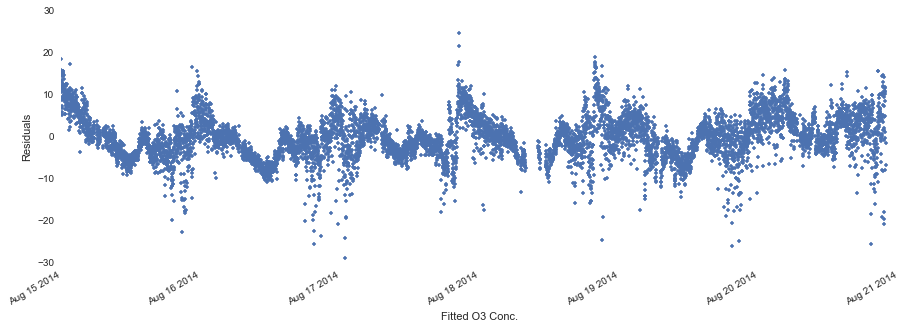

In [93]:
fitted_vs_ref_plot(df_fit_lasso, num_good_feat)
plot_fitted_and_ref_vs_time(df_fit_lasso, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_fit_lasso, pod_number, 2, ref_column)
resid = plot_resid_vs_conc(df_fit_lasso, ref_column)
plot_resid_vs_time(resid, pod_number, 1)
plot_resid_vs_time(resid, pod_number, 2)

#Partial Least Squares Regression

In [137]:
#fs_features = ['ln_O3_int_lead_5', 'Temp_int_lag_110', '03_mult_rh_sq', 'ln_rh_slope_lead_110', 'Rh_slope_lead_110', 'ln_temp_slope_lag_35', '03_mult_temp_cu', 'temp_rh_slope_lag_110', 'temp_rh_slope_lag_35', 'ln_temp_slope_lead_65', 'Temp_int_lead_20', 'Temp_slope_lag_65', 'diff', 'Temp_int_lead_5', 'o3_temp_rh_slope_lag_65', 'e2v03_int_lag_95', 'o3_temp_int_lag_95', 'ln_O3_int_lag_95', 'Temp_slope_lag_20', 'Temp_slope_lag_80', 'temp_rh_slope_lead_35', 'e2v03_slope_lead_95', 'o3_rh_int_lead_95', 'e2v03_slope_lead_80', 'ln_O3_slope_lag_20', 'ln_temp_slope_lead_80']
#num_good_feat = len(fs_features)
#print fs_features

In [138]:
#call the function that scales the features and creates a day column
df_fit, days = scale_features_and_create_day_column(df_all, fs_features[:num_good_feat], ref_column)

plsr = PLSRegression(max_iter = 500, n_components = 15)

#initialize the holdout and training MSE
day_date = []
MSE_H = [] 
#Calculate the training and holdout RSS for each step.
#take the mean MSE for all of the possible holdout days (giving cross-validation error)
for d in days:
                
    #call the function that defines the training and holdout data
    X_T, y_T, X_H, y_H = make_numpy_arrays_for_tr_and_holdout(fs_features[:num_good_feat], df_fit[df_fit.day != d], df_fit[df_fit.day == d], ref_column)  
    
    #fit the ridge regression for the lambda
    plsr.fit(X_T, y_T)
         
    #get the cross-validation MSE for the lambda and day
    MSE_H_day = int(np.mean((y_H - plsr.predict(X_H))**2))
    
    #record the MSE for lambda for the day
    MSE_H.append(MSE_H_day)

    #record the day
    day_date.append(d)
            
    #find the mean MSE of all of the days for the given value of lambda
    mean_MSE_all_days = np.mean(MSE_H)

    
print 'MSE Holdout: ', mean_MSE_all_days    

ValueError: invalid number of components

In [136]:
plsr = PLSRegression(max_iter = 500, n_components = 15)

for d in days:               
    #call the function that defines the training and holdout data
    X_T, y_T, X_H, y_H = make_numpy_arrays_for_tr_and_holdout(fs_features[:num_good_feat], df_fit[df_fit.day != d], df_fit[df_fit.day == d], ref_column)  
    
    #fit the ridge regression for the lambda
    plsr.fit(X_T, y_T)
    
    if d == days[0]:
        fitted_holdout_o3 = plsr.predict(X_H)
    else:
        fitted_holdout_o3 = np.concatenate((fitted_holdout_o3, plsr.predict(X_H)))

df_fit_plsr = df_all.copy()
df_fit_plsr['O3_fit'] = fitted_holdout_o3

AttributeError: 'DataFrame' object has no attribute 'day'

In [97]:
fitted_vs_ref_plot(df_fit_plsr, num_good_feat)
plot_fitted_and_ref_vs_time(df_fit_plsr, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_fit_plsr, pod_number, 2, ref_column)
resid = plot_resid_vs_conc(df_fit_plsr, ref_column)
plot_resid_vs_time(resid, pod_number, 1)
plot_resid_vs_time(resid, pod_number, 2)


TypeError: fitted_vs_ref_plot() takes exactly 2 arguments (1 given)

#Random Forest with all features

In [98]:
#fs_features = ['ln_O3_int_lead_5', 'Temp_int_lag_110', '03_mult_rh_sq', 'ln_rh_slope_lead_110', 'Rh_slope_lead_110', 'ln_temp_slope_lag_35', '03_mult_temp_cu', 'temp_rh_slope_lag_110', 'temp_rh_slope_lag_35', 'ln_temp_slope_lead_65', 'Temp_int_lead_20', 'Temp_slope_lag_65', 'diff', 'Temp_int_lead_5', 'o3_temp_rh_slope_lag_65', 'e2v03_int_lag_95', 'o3_temp_int_lag_95', 'ln_O3_int_lag_95', 'Temp_slope_lag_20', 'Temp_slope_lag_80', 'temp_rh_slope_lead_35', 'e2v03_slope_lead_95', 'o3_rh_int_lead_95', 'e2v03_slope_lead_80', 'ln_O3_slope_lag_20', 'ln_temp_slope_lead_80']
#num_good_feat = len(fs_features)

In [121]:
#choose to run default parameters or look for the best parameters (0 = default, 1 = other)
options = 0

In [126]:
import sklearn.ensemble as sk
i_max = 1 # max features
j_max = 1 # max depth
i_min = 0
j_min = 0

#fit random forest and finds MSE
def fit_rfr_and_find_MSE(features, df_F, df_H,d):
    #initialize the numpy array that will hold the test-mse data
    mse_array_test = np.zeros((i_max,j_max))
    mse_array_train = np.zeros((i_max,j_max))
    
    if options == 0:
        rfr = sk.RandomForestRegressor(n_estimators=100, oob_score = True, n_jobs = -1)
        forest = sk.RandomForestClassifier(n_estimators=100, random_state=0)
        
        #call the function that defines the trainig and holdout data
        X_T, y_T, X_H, y_H = make_numpy_arrays_for_tr_and_holdout(features, df_scaled[df_scaled.day != d], df_scaled[df_scaled.day == d], ref_column)                
        
        #fit a linear regression on the training data
        rfr.fit(X_T, y_T)  
        
        #fit the holdout data for the day
        df_H['O3_fit'] = rfr.predict(X_H)
        
        #plot the feature importances
        #plot_importance(rfr, forest)
        #plot_ref_and_pod_ozone_for_each_day(df_fit[df_fit.day != d], df_fit[df_fit.day == d])
        #plot_temp_and_rh_for_each_day(df_fit[df_fit.day != d], df_fit[df_fit.day == d])
        #plot_fitted_and_ref_ozone_for_each_day(df_H['O3_fit'], df_fit[df_fit.day == d])
        
        MSE_H = int(np.mean((y_H - rfr.predict(X_H))**2))
        MSE_T = int(np.mean((y_T - rfr.predict(X_T))**2))
            
        print d,'Holdout MSE: ', int(np.mean((y_H - rfr.predict(X_H))**2))
        return MSE_H, MSE_T
        
    else:
        #loop through all combinations of max_features and max_depth
        for i in range(i_min,i_max):
            j = j_min
            while j < j_max:
                #Set up the random forest regression features
                rfr = sk.RandomForestRegressor(n_estimators=250, oob_score = True, n_jobs = -1, max_features = i+1, max_depth = j+1)
                forest = sk.RandomForestClassifier(n_estimators=100, random_state=0)
                        
                #call the r=function that defines the trainig and holdout data
                X_T, y_T, X_H, y_H = make_numpy_arrays_for_tr_and_holdout(features, df_fit[df_fit.day != d], df_fit[df_fit.day == d], ref_column)
                
                #fit a linear regression on the training data
                rfr.fit(X_T, y_T)  
                #plot_importance(rfr, forest)
            
                #add the mse for each i and j to the 2D array (i is on one axis, j is on the other, and mse is a grid)
                mse_array_test[i,j] = int(np.mean((y_H - rfr.predict(X_H))**2))
                mse_array_train[i,j] = int(np.mean((y_T - rfr.predict(X_T))**2))
            
                print d,i,j,int(np.mean((y_H - rfr.predict(X_H))**2))
                j += 10
               
        #find the MSE for the training and holdout data
        return mse_array_test, mse_array_train

In [127]:
def plot_importance(rfr,forest):
    importances = rfr.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    print std
    indices = np.argsort(importances)[::-1]
    
    # Print the feature ranking
    print("Feature ranking:")
    for f in range(len(fs_features)):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]])),fs_features[indices[f]]
    
    #Plot the feature importances of the forest
    plt.figure(figsize=(15,5))
    plt.title("Feature importances")
    plt.bar(range(len(fs_features)), importances[indices], color="r", align="center")
    #, yerr = std[indices]
    plt.xticks(range(len(fs_features)), indices)
    plt.xlim([-1, len(fs_features)])
    plt.show()
    
def plot_temp_and_rh_for_each_day(df_T, df_H):
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    plt.title('Temp and Rh Data', fontsize = 30)
    ax.plot(df_H['Temp'],  color="r", marker = '.', linestyle = '--', label = 'reference')
    ax.set_xlabel('Time', fontsize = 18)
    ax.set_ylabel('Temperature (as % of maximum)', fontsize = 18)
    ax.legend()
    
    ax2 = ax.twinx()  
    ax2.set_ylabel('Rel. Hum. (as % of maximum)', fontsize = 18)
    ax2.legend(loc = 0)
    plt.plot((df_H['Rh']), marker = '.', linestyle = '--', label = 'pod')
    plt.show()
    
def plot_ref_and_pod_ozone_for_each_day(df_T, df_H):
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    plt.title('Pod and Reference Ozone Data', fontsize = 30)
    ax.plot(df_H['O3_ppb'], color="r", marker = '.', linestyle = '--', label = 'reference')
    ax.set_xlabel('Time', fontsize = 18)
    ax.set_ylabel('Reference Ozone', fontsize = 18)
    ax.legend()
    
    
    df_H['ones'] = 1
    df_H['inverse_o3'] = df_H['ones'].div(df_H['e2v03'], axis='index')
    ax2 = ax.twinx()  
    ax2.set_ylabel('Pod Ozone (1/mV)', fontsize = 18)
    ax2.legend(loc = 0)
    plt.plot((df_H['inverse_o3']), marker = '.', linestyle = '--', label = 'pod')
    plt.show()
    
    
def plot_fitted_and_ref_ozone_for_each_day(fitted_data, df_H):
    plt.figure(figsize=(15,5))
    plt.title('Fitted and Ref. Ozone Data', fontsize = 30)
    fitted_data.plot(color="r", marker = '.', label = 'fitted')
    plt.xlabel('Time', fontsize = 18)
    plt.ylabel('Ozone (ppb)', fontsize = 18)
    plt.legend() 
    df_H['O3_ppb'].plot(label = 'reference')
    plt.show()

In [128]:
def find_daily_min_max(features, df_T, df_H,d):
    X_T = df_T[features]
    X_H = df_H[features]
    y_T = df_T['O3_ppb']
    y_H = df_H['O3_ppb']
    return y_H.max(), df_H['Temp'].max(), df_H['Rh'].max(), y_H.min(), df_H['Temp'].min(), df_H['Rh'].min(), y_H.mean(), df_H['Temp'].mean(), df_H['Rh'].mean(), y_H.std(), df_H['Temp'].std(), df_H['Rh'].std(), df_H['e2v03'].max(), df_H['e2v03'].min(), df_H['e2v03'].mean(), df_H['e2v03'].std()

In [129]:
# define the dataset
import sklearn.preprocessing as pp

#call the function that scales the features and creates a day column
df_fit, days = scale_features_and_create_day_column(df_all, features, ref_column)
        
#initialize the holdout and training RSS
MSE_T = []
MSE_H = [] 
day_date = []
o3_max = []
rh_max_percent = []
temp_max_percent = []
o3_min = []
rh_min_percent = []
temp_min_percent = []
o3_mean = []
rh_mean_percent = []
temp_mean_percent = []
o3_stdev = []
rh_stdev_percent = []
temp_stdev_percent = []
pod_o3_max = []
pod_o3_min = []
pod_o3_mean = []
pod_o3_stdev = []

count = 1
#Calculate the training and holdout RSS for each step.
#take the mean MSE for all of the possible holdout days (giving cross-validation error)
for d in days:
    MSE_H_day, MSE_T_day = fit_rfr_and_find_MSE(fs_features, df_fit[df_fit.day != d], df_fit[df_fit.day == d],d)
    
    day_date.append(d)
    #count_append.append(count)
    
    if count == 1 and options == 1:
        MSE_H = MSE_H_day
        MSE_T = MSE_T_day
    elif count == 1:
        MSE_H.append(MSE_H_day)
        MSE_T.append(MSE_T_day)
    elif options == 1:
        MSE_H = np.dstack((MSE_H,MSE_H_day))
        MSE_T = np.dstack((MSE_T,MSE_T_day))
    else:
        MSE_H.append(MSE_H_day)
        MSE_T.append(MSE_T_day)
        
    count +=1

    
    #call the function that finds the daily min and max
    o3_max_day, temp_max_day, rh_max_day, o3_min_day, temp_min_day, rh_min_day, o3_mean_day, temp_mean_day, rh_mean_day, o3_stdev_day, temp_stdev_day, rh_stdev_day, pod_o3_max_day, pod_o3_min_day, pod_o3_mean_day, pod_o3_stdev_day = find_daily_min_max(features, df_fit[df_fit.day != d], df_fit[df_fit.day == d],d)
    o3_max.append(o3_max_day)
    temp_max_percent.append(temp_max_day*100)
    rh_max_percent.append(rh_max_day*100)
    o3_min.append(o3_min_day)
    temp_min_percent.append(temp_min_day*100)
    rh_min_percent.append(rh_min_day*100)
    o3_mean.append(o3_mean_day)
    temp_mean_percent.append(temp_mean_day*100)
    rh_mean_percent.append(rh_mean_day*100)
    o3_stdev.append(o3_stdev_day)
    temp_stdev_percent.append(temp_stdev_day*100)
    rh_stdev_percent.append(rh_stdev_day*100)
    pod_o3_max.append(pod_o3_max_day)
    pod_o3_min.append(pod_o3_min_day)
    pod_o3_mean.append(pod_o3_mean_day)
    pod_o3_stdev.append(pod_o3_stdev_day)
    
       
#drop the day column
df_fit.drop('day', axis=1, inplace=True)

7-11 Holdout MSE:  223
7-12 Holdout MSE:  45
8-15 Holdout MSE:  52
8-16 Holdout MSE:  42
8-17 Holdout MSE:  48
8-18 Holdout MSE:  27
8-19 Holdout MSE:  30
8-20 Holdout MSE:  27


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipython-3.1.0-py2.7.egg/IPython/kernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [130]:
if options == 1:
    #first array is  [[day 1, day 2, ..., day n (i = 0 & j = 0)] [day 1, day 2, ..., day n (i = 0, j = 1)] [day 1, day 2, ..., day n(i = 0, j = n)]
    #second array is [[day 1, day 2, ..., day n (i = 1 & j = 0)] [day 1, day 2, ..., day n (i = 1, j = 1)] [day 1, day 2, ..., day n(i = 1, j = n)]
    #nth array is [[day 1, day 2, ..., day n (i = n & j = 0)] [day 1, day 2, ..., day n (i = n, j = 1)] [day 1, day 2, ..., day n(i = n, j = n)]
    print MSE_H
else: 
    print 'mean MSE = ', int(np.mean(MSE_H))
    print 'Daily MSE = ' + str(MSE_H)

mean MSE =  61
Daily MSE = [223, 45, 52, 42, 48, 27, 30, 27]


In [131]:
if options == 1:
    MSE_H_per_day = MSE_H.mean(axis=2, dtype = int)
    print MSE_H_per_day

In [132]:
if options == 1:    
    fig = plt.figure(figsize=(20, 20))

    ax = fig.add_subplot(111)
    ax.set_title('colorMap')
    imgplot = plt.imshow(MSE_H_per_day)
    imgplot.set_cmap('hot')
    #imgplot.set_clim(60,71)
    ax.set_aspect('equal')

    plt.colorbar(orientation='vertical')
    plt.show()
    plt.xlabel('Maximum Tree Depth')
    plt.ylabel('Maximum Features at Each Split')

In [133]:
if options == 1:
    min_MSE_H = MSE_H_per_day.min()
    i,j = np.where(MSE_H_per_day == min_MSE_H)
    i = i + 1
    j = (j + 1)*5
    print 'Max features = ' + str(i)
    print 'Max depth = ' + str(j)
    print 'MSE for the holdout data = ' + str(min_MSE_H)

In [134]:
####Plot the holdout data MSE for each day.

In [135]:
def plot_daily_mse_and_features_for_day(MSE_H, day_date,feat_to_compare, title, sec_axis_label):
    from matplotlib import rc
    rc('mathtext', default='regular')

    indices = day_date
    
    #Plot the feature importances of the forest
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    plt.title(title, fontsize = 30)
    ax.bar(range(len(day_date)), MSE_H,  color="r", align="center")
    plt.xticks(range(len(day_date)), indices)
    plt.xlim([-1, len(day_date)])
    ax.set_xlabel('Date', fontsize = 18)
    ax.set_ylabel('MSE (ppb)', fontsize = 18)
    ax2 = ax.twinx()  
    ax2.set_ylabel(sec_axis_label, fontsize = 18)
    plt.plot(range(len(day_date)), feat_to_compare, marker = 'o', linestyle = '--')
    plt.show()

In [ ]:
#plot_daily_mse_and_features_for_day(MSE_H, day_date, o3_mean,'Mean Ozone', 'ppb')
#plot_daily_mse_and_features_for_day(MSE_H, day_date, o3_stdev,'St. Dev. in Ozone', 'ppb')
#plot_daily_mse_and_features_for_day(MSE_H, day_date, temp_mean_percent,'Mean Temp.','% of Max. during Collocation')
#plot_daily_mse_and_features_for_day(MSE_H, day_date, temp_stdev_percent,'St. Dev.','% of Max. during Collocation')
#plot_daily_mse_and_features_for_day(MSE_H, day_date, rh_mean_percent,'Mean Rel. Humid.','% of Max. during Collocation')
#plot_daily_mse_and_features_for_day(MSE_H, day_date, rh_stdev_percent,'St. Dev. Rel. Humid.','% of Max. during Collocation')
#plot_daily_mse_and_features_for_day(MSE_H, day_date, pod_o3_mean,'Mean Pod Ozone','% of Max. during Collocation')
#plot_daily_mse_and_features_for_day(MSE_H, day_date, pod_o3_stdev,'St. Dev. Pod Ozone','% of Max. during Collocation')

###Plot the learning curves

In [139]:
cv = lol
ylim = (0,60)
train_sizes = np.array([ 0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0])
#declare the reference data 
y = df_all[ref_column].values

for i in range(1,30):
    X = df_all[fs_features[:i]].values 
    title = "Learning Curve- Number of features = " + str(i)
    plot_learning_curve(rfr, title, X, y, ylim, cv, train_sizes, 'mean_squared_error')

NameError: name 'rfr' is not defined

In [140]:
fitted_holdout_o3 = []
for d in days:
    
    #call the df_subset function to make numpy arrays out of the training and holdout data
    X_T, y_T, X_H, y_H = make_numpy_arrays_for_tr_and_holdout(features[:num_good_feat], df_scaled[df_scaled.day != d], df_scaled[df_scaled.day == d], ref_column) 
    
    #fit a linear regression on the training data
    rfr = sk.RandomForestRegressor(n_estimators=100, oob_score = True, n_jobs = -1)
    rfr.fit(X_T, y_T)
        
    if d == days[0]:
        fitted_holdout_o3 = rfr.predict(X_H)
    else:
        fitted_holdout_o3 = np.concatenate((fitted_holdout_o3, rfr.predict(X_H)))

df_fit_rf = df_all.copy()
df_fit_rf['O3_fit'] = fitted_holdout_o3

#drop the day column
df_fit.drop('day', axis=1, inplace=True)

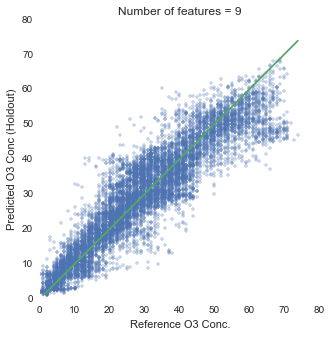

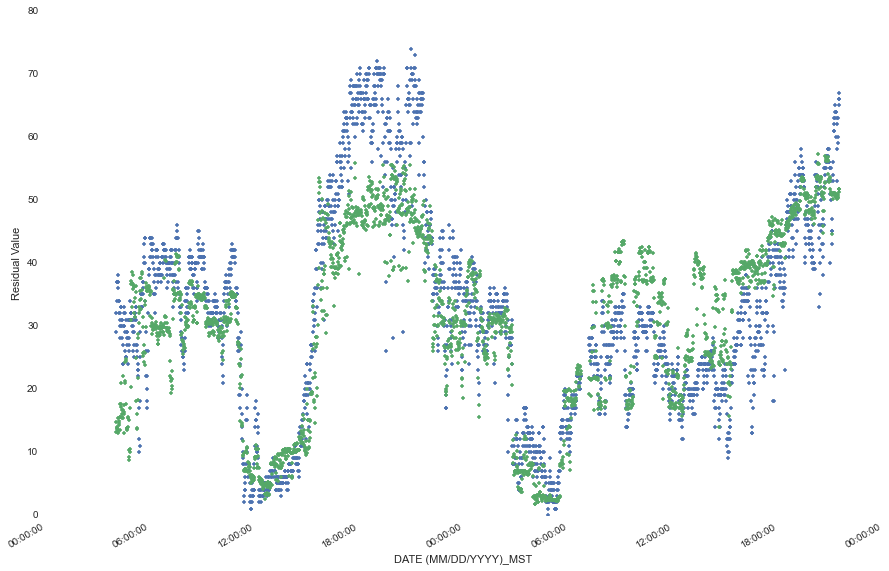

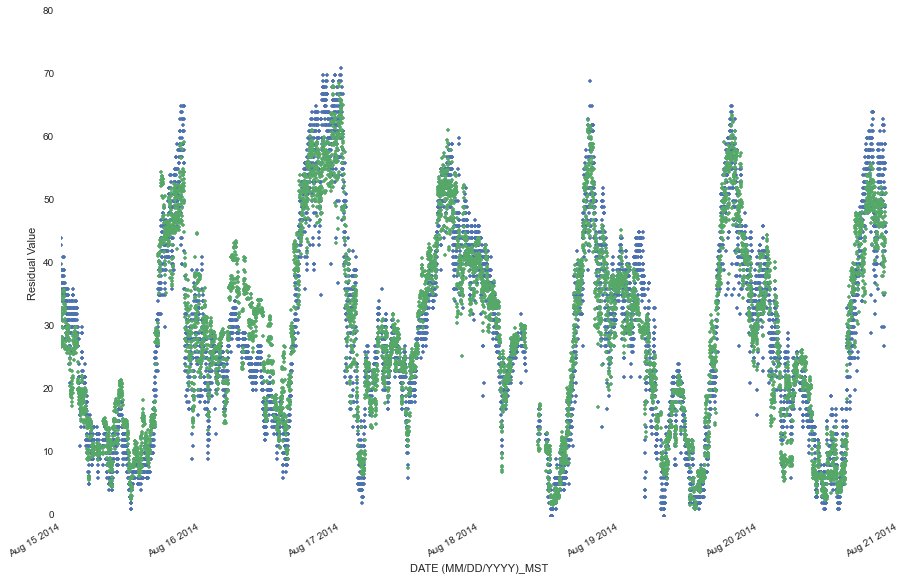

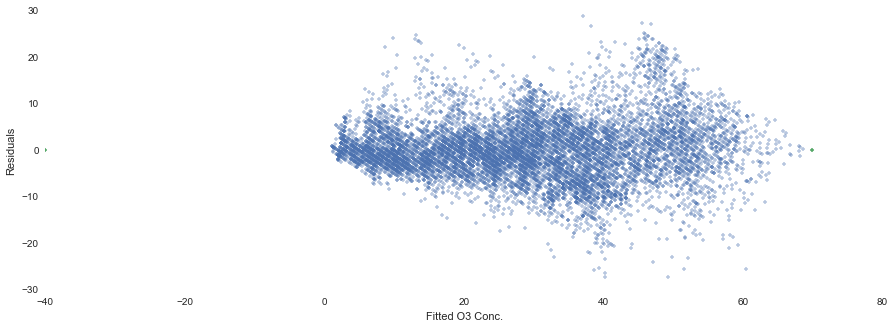

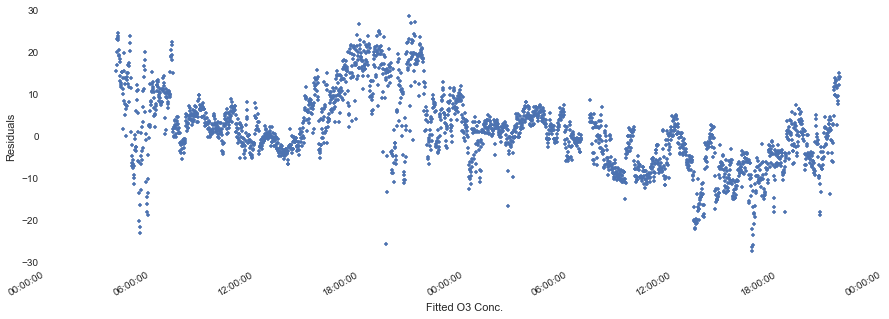

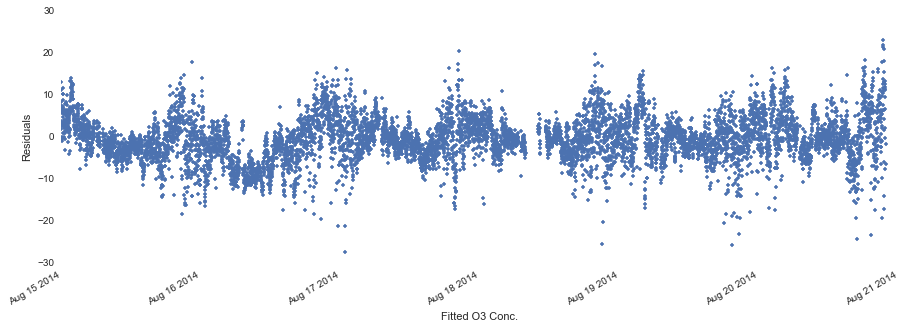

In [142]:
fitted_vs_ref_plot(df_fit_rf, num_good_feat)
plot_fitted_and_ref_vs_time(df_fit_rf, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf, pod_number, 2, ref_column)
resid = plot_resid_vs_conc(df_fit_rf, ref_column)
plot_resid_vs_time(resid, pod_number, 1)
plot_resid_vs_time(resid, pod_number, 2)

#Vector Support Machine

In [181]:
fs_features = ['ln_03_mult_ln_rh', 'UnixTime', 'ln_rh_slope_lag_110', 'temp_cu', 'ln_03_mult_ln_temp', 'o3_rh_int_lag_95', 'ln_rh_slope_lead_110', 'ln_O3_int_lag_110', 'o3_temp_int_lag_35', 'ln_o3_rh_slope_lead_110', 'ln_temp_slope_lag_95', 'Temp_slope_lag_80', 'ln_o3_rh_int_lead_35', 'ln_o3_temp_int_lead_95', 'ln_temp_rh_slope_lead_65', 'Temp_slope_lag_95', 'ln_rh_slope_lag_5', '03_sq_mult_rh_sq_&_temp_sq', 'e2v03_int_slide_2_to_12_lead', 'ln_O3_int_slide_2_to_12_lead', 'Temp_int_slide_2_to_12_lead', 'ln_temp_int_slide_2_to_12_lead', 'Rh_int_slide_2_to_12_lead', 'ln_rh_int_slide_2_to_12_lead', 'diff', 'Temp_slope_lead_20', 'ln_rh_slope_lead_5', 'ln_rh_slope_lead_20', 'ln_o3_temp_slope_lag_65', 'o3_temp_slope_lag_95', 'ln_o3_rh_slope_lag_95', 'o3_rh_slope_lag_95', 'ln_o3_temp_slope_lag_110', 'ln_o3_temp_slope_lag_35', 'Temp_slope_lead_5', 'Temp_slope_lag_20']
num_good_feat = 25

In [186]:
#define the training data
df_vsm = df_scaled[fs_features[:num_good_feat] + [ref_column] + ['day']].dropna()
X = df_scaled[fs_features[:num_good_feat]].values
y = df_scaled[ref_column].values

In [187]:
from sklearn.svm import SVR
from sklearn.grid_search import GridSearchCV

def fit_vsm_and_find_MSE(features, df_T, df_H, d, days, fitted_holdout_o3, lol):
        
    X_T, y_T, X_H, y_H = make_numpy_arrays_for_tr_and_holdout(features, df_scaled[df_scaled.day != d], df_scaled[df_scaled.day == d], ref_column)   

    # Set the parameters by cross-validation
    #vsm = GridSearchCV(svm.SVR(kernel='rbf', gamma=0.1), cv=lol, param_grid={"C": [1, 10, 100, 1000], "gamma": [1e-3, 1e-4]}, scoring = make_scorer(custom_mse_scoring_function, greater_is_better = False))
    #vsm = SVR(C=1.0, epsilon=0.2)
    
    parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
    svr = SVR()
    vsm = GridSearchCV(svr, parameters)
    vsm.fit(X_T, y_T)  
    
    
    if d == days[0]:
        fitted_holdout_o3 = vsm.predict(X_H)
    else:
        fitted_holdout_o3 = np.concatenate((fitted_holdout_o3, vsm.predict(X_H)))
        
    MSE_CV = int(np.mean((y_H - vsm.predict(X_H))**2))
    
    print d,'Cross-Val MSE: ', MSE_CV
    print vsm.get_params
    return MSE_CV, fitted_holdout_o3

In [188]:
#Calculate the training and holdout MSE for each step.
#take the mean MSE for all of the possible holdout days (giving cross-validation error)
MSE_CV = []
day_date = []
df_svm_fit = df_scaled.copy()

for d in days:
    MSE_H_day, fitted_holdout_o3 = fit_vsm_and_find_MSE(fs_features, df_scaled[df_scaled.day != d], df_scaled[df_scaled.day == d],d, days, fitted_holdout_o3, lol)  
    day_date.append(d)  
    MSE_CV.append(MSE_H_day)
    
df_svm_fit['o3_fit'] = fitted_holdout_o3    
print 'Cross-Validation Holdout MSE: ', np.mean(MSE_H)
print 'Daily Cross-Validation MSE: ', MSE_CV

7-11 Cross-Val MSE:  112
<bound method GridSearchCV.get_params of GridSearchCV(cv=None,
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'kernel': ('linear', 'rbf'), 'C': [1, 10]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)>
7-12 Cross-Val MSE:  74
<bound method GridSearchCV.get_params of GridSearchCV(cv=None,
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'kernel': ('linear', 'rbf'), 'C': [1, 10]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbo

KeyboardInterrupt: 

In [74]:
vsm.get_params

NameError: name 'vsm' is not defined

In [59]:
fitted_vs_ref_plot(df_fit_lasso, num_good_feat)
plot_fitted_and_ref_vs_time(df_fit_lasso, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_fit_lasso, pod_number, 2, ref_column)
resid = plot_resid_vs_conc(df_fit_lasso, ref_column)
plot_resid_vs_time(resid, pod_number, 1)
plot_resid_vs_time(resid, pod_number, 2)

NameError: name 'df_fit_lasso' is not defined

In [ ]:
from sklearn.svm import SVR
from sklearn.grid_search import GridSearchCV

def fit_vsm_and_find_MSE(features, df_T, df_H, d, days, fitted_holdout_o3, lol):
    
    parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
    svr = SVR()
    vsm = GridSearchCV(svr, parameters, scoring = make_scorer(custom_mse_scoring_function, greater_is_better = False), cv = lol)
    vsm.fit(X_T, y_T)  
    
    
    if d == days[0]:
        fitted_holdout_o3 = vsm.predict(X_H)
    else:
        fitted_holdout_o3 = np.concatenate((fitted_holdout_o3, vsm.predict(X_H)))
        
    MSE_CV = int(np.mean((y_H - vsm.predict(X_H))**2))
    
    print d,'Cross-Val MSE: ', MSE_CV
    print vsm.get_params
    return MSE_CV, fitted_holdout_o3

In [ ]:
def avg_cv_score_for_all_days(df, features, ref_column, model, scoring_metric):
    X = df[features].values
    y = df[ref_column].values
    if scoring_metric == 'custom_mse':
        score_cv = -np.mean(cross_val_score(model, X, y, cv = lol, scoring = make_scorer(custom_mse_scoring_function, greater_is_better = False)))        
    elif scoring_metric == 'custom_mae':
        score_cv = -np.mean(cross_val_score(model, X, y, cv = lol, scoring = make_scorer(custom_mae_scoring_function, greater_is_better = False)))        
    else:
        score_cv = -np.mean(cross_val_score(model, X, y, cv = lol, scoring = scoring_metric))
    return score_cv

#AdaBoost

In [ ]:
import sklearn.tree as tsk

#dt1 = tsk.DecisionTreeRegressor(max_depth=4) create single tree
ada = sk.AdaBoostRegressor(n_estimators = 175, learning_rate = 3)
staged_score = (X,y)

#dt1_reg = dt1.fit(X,y)   
ada_reg = ada.fit(X,y)

In [ ]:
#Get the Ada Boost classifier results
ada_cv = sk.AdaBoostClassifier(n_estimators = 175, learning_rate = 3)
#get the cross-validation scores
scores = cvs(ada_cv, X, y, cv = 10, scoring='r2')
scores.mean() 